In [3]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

Loading Tiger: 100%|██████████| 39/39 [00:08<00:00,  4.83it/s]


Loaded 170 images across 5 categories.


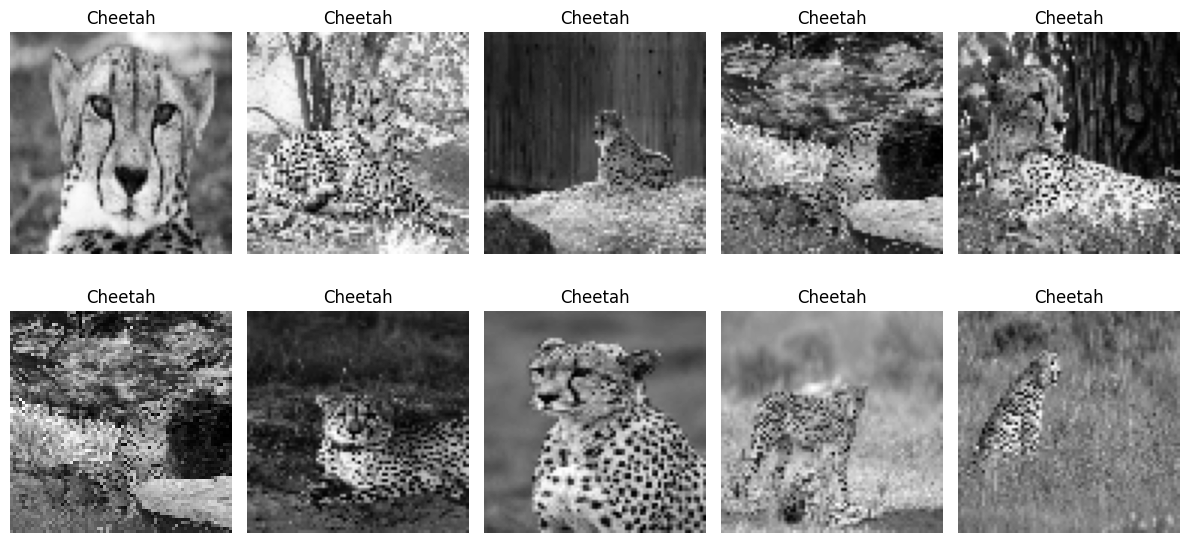

In [4]:
# data file path
data_path = "/content/drive/MyDrive/CVPR/Assignment 1/Animals"

# List of subfolders within 'data_path'
categories = ["Cheetah", "Jaguar", "Leopard", "Lion", "Tiger"]

def load_images_from_folder():
    images = []
    labels = []
    for c in categories:
        path = os.path.join(data_path, c)
        for img in tqdm(os.listdir(path), desc=f"Loading {c}"):
            img_path = os.path.join(path, img)
            if os.path.isfile(img_path):
                img_arr = cv2.imread(img_path)
                if img_arr is not None:
                    img_arr = cv2.resize(img_arr, (74, 74))
                    gray_img = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
                    images.append(gray_img)
                    labels.append(c)
    return np.array(images), np.array(labels)

# Loading the dataset
images, labels = load_images_from_folder()
print(f"Loaded {len(images)} images across {len(categories)} categories.")

def display_images(images, labels, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the first 10 images
display_images(images, labels, num_images=10)


In [5]:
def euclidean_distance(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))

In [6]:
def knn_classify(test_image, train_images, train_labels, k):
    distances = []
    for i in range(len(train_images)):
        distance = euclidean_distance(test_image, train_images[i])
        distances.append((distance, train_labels[i]))
    distances.sort(key=lambda x: x[0])  # Sort by distance
    nearest_neighbors = [label for _, label in distances[:k]]

    # count occurrences of each label
    label_counts = {}
    for label in nearest_neighbors:
        label_counts[label] = label_counts.get(label, 0) + 1

    most_common_label = max(label_counts, key=label_counts.get)
    return most_common_label

In [7]:
def k_fold_split(images, labels, k_folds=5):
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    fold_size = len(images) // k_folds

    for i in range(k_folds):
        test_indices = indices[i * fold_size : (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
        yield images[train_indices], images[test_indices], labels[train_indices], labels[test_indices]

In [8]:
k_values = range(1, 31)  # K values from 1 to 30
accuracies = {k: [] for k in k_values}

# 5-fold cross-validation
for X_train, X_test, y_train, y_test in k_fold_split(images, labels):
    for k in tqdm(k_values, desc="Evaluating K values"):
        correct = 0
        for i in range(len(X_test)):
            prediction = knn_classify(X_test[i], X_train, y_train, k)
            if prediction == y_test[i]:
                correct += 1
        accuracy = correct / len(X_test)
        accuracies[k].append(accuracy)

# average accuracy for each K
avg_accuracies = {k: np.mean(acc) for k, acc in accuracies.items()}

Evaluating K values: 100%|██████████| 30/30 [00:02<00:00, 12.05it/s]


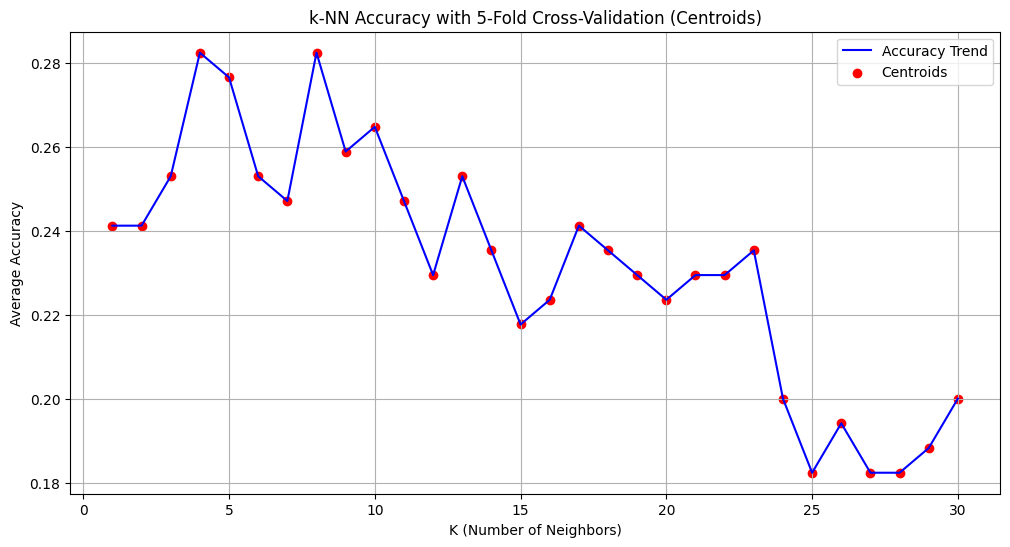

In [9]:
k_list = list(avg_accuracies.keys())
accuracy_list = list(avg_accuracies.values())

plt.figure(figsize=(12, 6))
plt.plot(k_list, accuracy_list, linestyle='-', color='blue', label='Accuracy Trend')  # Line connecting centroids
plt.scatter(k_list, accuracy_list, color='red', label='Centroids')  # Centroid points

plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Average Accuracy')
plt.title('k-NN Accuracy with 5-Fold Cross-Validation (Centroids)')
plt.grid(True)
plt.legend()

plt.show()